<a href="https://colab.research.google.com/github/SelenArikan/Plant/blob/main/Plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "YOUR_KAGGLE_USERNAME_HERE"
os.environ['KAGGLE_KEY'] = "d79ba611e44d21ed31b67d65d3781bf2"

!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plant_disease_data

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
y
 76% 503M/658M [00:00<00:00, 1.75GB/s]
100% 658M/658M [00:00<00:00, 1.67GB/s]


In [ ]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


if os.path.exists('./plant_disease_data/PlantVillage'):
    data_dir = './plant_disease_data/PlantVillage'
elif os.path.exists('./plant_disease_data/plantvillage'):
    data_dir = './plant_disease_data/plantvillage'
else:

    data_dir = './plant_disease_data'

print(f"Loading data from: {data_dir}")

try:
    full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)


    if len(full_dataset.classes) <= 1:
        print("\n CRITICAL ERROR: Still only found 1 class. Checking deeper...")
        possible_path = os.path.join(data_dir, 'PlantVillage')
        if os.path.exists(possible_path):
            data_dir = possible_path
            full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
            print(f"Fixed! Found data at: {data_dir}")

    print(f"Classes found: {len(full_dataset.classes)}")
    print(f"Example classes: {full_dataset.classes[:5]}")

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

except Exception as e:
    print(f"Error: {e}")

Loading data from: ./plant_disease_data/PlantVillage
Classes found: 15
Example classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Train size: 16510, Test size: 4128


In [ ]:

def get_teacher_model(num_classes):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)
class StudentCNN(nn.Module):
    def __init__(self, num_classes):
        super(StudentCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
if 'full_dataset' in globals():
    num_classes = len(full_dataset.classes)
    teacher = get_teacher_model(num_classes)
    student = StudentCNN(num_classes).to(device)
    print("Teacher unlocked for full training!")

Teacher unlocked for full training!


In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.7):
        super(DistillationLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_student = F.log_softmax(student_logits / self.T, dim=1)
        soft_teacher = F.softmax(teacher_logits / self.T, dim=1)
        loss_kd = self.kl_div(soft_student, soft_teacher) * (self.T ** 2)
        loss_ce = self.ce_loss(student_logits, labels)
        total_loss = (self.alpha * loss_kd) + ((1 - self.alpha) * loss_ce)
        return total_loss

In [ ]:
def train_model(model, loader, optimizer, criterion, device, teacher_model=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    if teacher_model:
        teacher_model.eval()

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        if teacher_model:
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = criterion(outputs, teacher_outputs, labels)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

In [ ]:


print("--- Training Teacher (ResNet18 - Full Fine Tuning) ---")


optimizer_teacher = optim.Adam(teacher.parameters(), lr=1e-4)
criterion_ce = nn.CrossEntropyLoss()
epochs_teacher = 20

for epoch in range(epochs_teacher):
    loss, acc = train_model(teacher, train_loader, optimizer_teacher, criterion_ce, device)
    val_acc = evaluate_model(teacher, test_loader, device)
    print(f"Teacher Epoch {epoch+1}/{epochs_teacher} | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")

print(f"Teacher Training Complete. Final Accuracy: {val_acc:.2f}%")

--- Training Teacher (ResNet18 - Full Fine Tuning) ---
Teacher Epoch 1/20 | Loss: 0.2499 | Train Acc: 93.28% | Val Acc: 98.18%
Teacher Epoch 2/20 | Loss: 0.0551 | Train Acc: 98.43% | Val Acc: 97.80%
Teacher Epoch 3/20 | Loss: 0.0370 | Train Acc: 98.87% | Val Acc: 99.22%
Teacher Epoch 4/20 | Loss: 0.0317 | Train Acc: 99.10% | Val Acc: 98.69%
Teacher Epoch 5/20 | Loss: 0.0195 | Train Acc: 99.52% | Val Acc: 98.84%
Teacher Epoch 6/20 | Loss: 0.0233 | Train Acc: 99.30% | Val Acc: 99.27%
Teacher Epoch 7/20 | Loss: 0.0193 | Train Acc: 99.47% | Val Acc: 99.06%
Teacher Epoch 8/20 | Loss: 0.0189 | Train Acc: 99.36% | Val Acc: 99.39%
Teacher Epoch 9/20 | Loss: 0.0168 | Train Acc: 99.48% | Val Acc: 99.03%
Teacher Epoch 10/20 | Loss: 0.0148 | Train Acc: 99.53% | Val Acc: 99.47%
Teacher Epoch 11/20 | Loss: 0.0171 | Train Acc: 99.47% | Val Acc: 99.52%
Teacher Epoch 12/20 | Loss: 0.0099 | Train Acc: 99.73% | Val Acc: 99.37%
Teacher Epoch 13/20 | Loss: 0.0119 | Train Acc: 99.61% | Val Acc: 99.30%
Teach

In [ ]:
student_scratch = StudentCNN(num_classes).to(device)
optimizer_scratch = optim.Adam(student_scratch.parameters(), lr=0.001)
criterion_ce = nn.CrossEntropyLoss()
history_scratch = []

for epoch in range(epochs):
    loss, acc = train_model(student_scratch, train_loader, optimizer_scratch, criterion_ce, device)
    val_acc = evaluate_model(student_scratch, test_loader, device)
    history_scratch.append(val_acc)
    print(f"Student(No KD) Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_kd, step_size=7, gamma=0.1)



Student(No KD) Epoch 1/20 | Loss: 1.2370 | Train Acc: 59.87% | Val Acc: 78.20%
Student(No KD) Epoch 2/20 | Loss: 0.7297 | Train Acc: 75.98% | Val Acc: 85.00%
Student(No KD) Epoch 3/20 | Loss: 0.5890 | Train Acc: 80.73% | Val Acc: 85.34%
Student(No KD) Epoch 4/20 | Loss: 0.4825 | Train Acc: 83.43% | Val Acc: 88.47%
Student(No KD) Epoch 5/20 | Loss: 0.4222 | Train Acc: 85.97% | Val Acc: 90.43%
Student(No KD) Epoch 6/20 | Loss: 0.3790 | Train Acc: 87.41% | Val Acc: 92.56%
Student(No KD) Epoch 7/20 | Loss: 0.3445 | Train Acc: 88.32% | Val Acc: 89.73%
Student(No KD) Epoch 8/20 | Loss: 0.3232 | Train Acc: 89.18% | Val Acc: 91.18%
Student(No KD) Epoch 9/20 | Loss: 0.2966 | Train Acc: 90.08% | Val Acc: 93.02%
Student(No KD) Epoch 10/20 | Loss: 0.2792 | Train Acc: 90.67% | Val Acc: 93.05%
Student(No KD) Epoch 11/20 | Loss: 0.2600 | Train Acc: 91.34% | Val Acc: 93.10%
Student(No KD) Epoch 12/20 | Loss: 0.2427 | Train Acc: 92.14% | Val Acc: 94.38%
Student(No KD) Epoch 13/20 | Loss: 0.2252 | Train

In [ ]:
student_kd = StudentCNN(num_classes).to(device)
optimizer_kd = optim.Adam(student_kd.parameters(), lr=0.001)
kd_criterion = DistillationLoss(temperature=4.0, alpha=0.7)
history_kd = []

for epoch in range(epochs):
    loss, acc = train_model(student_kd, train_loader, optimizer_kd, kd_criterion, device, teacher_model=teacher)
    val_acc = evaluate_model(student_kd, test_loader, device)
    history_kd.append(val_acc)
    print(f"Student(KD) Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_kd, step_size=7, gamma=0.1)

Student(KD) Epoch 1/20 | Loss: 9.8452 | Train Acc: 60.81% | Val Acc: 78.49%
Student(KD) Epoch 2/20 | Loss: 6.5649 | Train Acc: 76.63% | Val Acc: 87.04%
Student(KD) Epoch 3/20 | Loss: 5.4012 | Train Acc: 82.26% | Val Acc: 87.74%
Student(KD) Epoch 4/20 | Loss: 4.7524 | Train Acc: 85.35% | Val Acc: 90.60%
Student(KD) Epoch 5/20 | Loss: 4.1963 | Train Acc: 88.43% | Val Acc: 92.49%
Student(KD) Epoch 6/20 | Loss: 3.8468 | Train Acc: 89.67% | Val Acc: 92.83%
Student(KD) Epoch 7/20 | Loss: 3.6281 | Train Acc: 90.96% | Val Acc: 93.00%
Student(KD) Epoch 8/20 | Loss: 3.4839 | Train Acc: 91.65% | Val Acc: 94.65%
Student(KD) Epoch 9/20 | Loss: 3.2891 | Train Acc: 92.65% | Val Acc: 93.39%
Student(KD) Epoch 10/20 | Loss: 3.1520 | Train Acc: 93.08% | Val Acc: 94.31%
Student(KD) Epoch 11/20 | Loss: 3.0467 | Train Acc: 93.49% | Val Acc: 94.45%
Student(KD) Epoch 12/20 | Loss: 2.9911 | Train Acc: 94.00% | Val Acc: 95.18%
Student(KD) Epoch 13/20 | Loss: 2.8522 | Train Acc: 94.71% | Val Acc: 95.62%
Student(

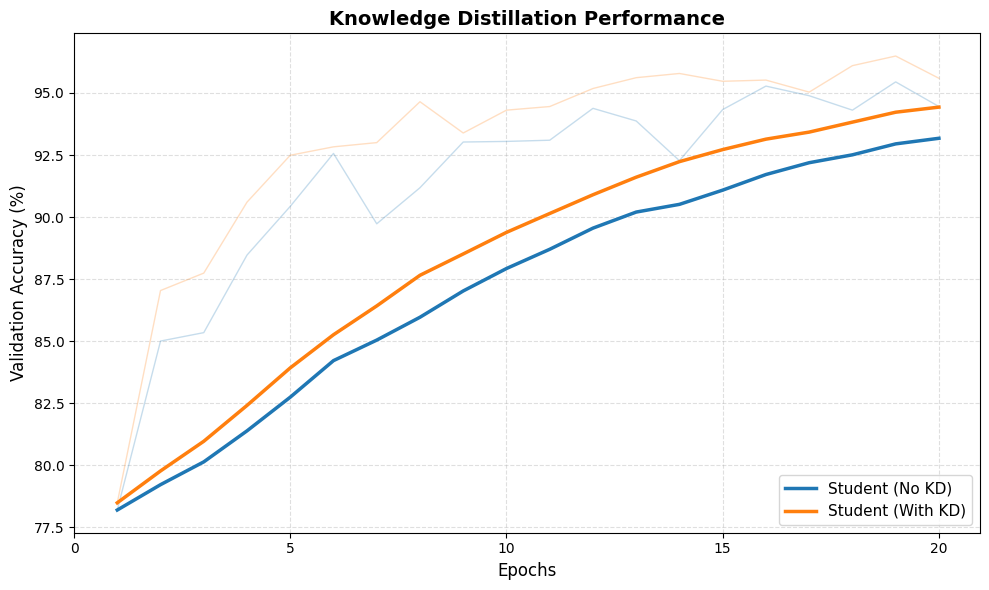

Model                     | Max Accuracy | Final Accuracy
------------------------------------------------------------
Teacher (ResNet)          | 99.76%      | -
Student (No KD)           | 95.45%      | 94.45%
Student (With KD)         | 96.49%      | 95.59%


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.85):
    """
    Veriyi yumuşatmak için Exponential Moving Average (EMA) uygular.
    factor: 0.0 ile 1.0 arasında olmalıdır.
    0.9 çok pürüzsüz yapar, 0.6 daha az pürüzsüz yapar.
    Akademik grafikler için genelde 0.8 - 0.9 arası kullanılır.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
epochs_range = range(1, len(history_scratch) + 1)
smooth_scratch = smooth_curve(history_scratch, factor=0.85)
smooth_kd = smooth_curve(history_kd, factor=0.85)
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(epochs_range, history_scratch, color='tab:blue', alpha=0.25, linewidth=1)
plt.plot(epochs_range, history_kd, color='tab:orange', alpha=0.25, linewidth=1
plt.plot(epochs_range, smooth_scratch, label='Student (No KD)', color='tab:blue', linewidth=2.5)
plt.plot(epochs_range, smooth_kd, label='Student (With KD)', color='tab:orange', linewidth=2.5)
plt.title('Knowledge Distillation Performance', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(np.arange(0, len(history_scratch)+1, 5))

plt.tight_layout()
plt.show()
print(f"{'Model':<25} | {'Max Accuracy':<10} | {'Final Accuracy':<10}")
print("-" * 60)
print(f"{'Teacher (ResNet)':<25} | {evaluate_model(teacher, test_loader, device):.2f}%      | -")
print(f"{'Student (No KD)':<25} | {max(history_scratch):.2f}%      | {history_scratch[-1]:.2f}%")
print(f"{'Student (With KD)':<25} | {max(history_kd):.2f}%      | {history_kd[-1]:.2f}%")

In [ ]:
# Debug Cell: Check classes
print("Number of classes found:", len(full_dataset.classes))
print("Class names:", full_dataset.classes)

# Check directory structure
import os
print("\nFiles in data folder:")
print(os.listdir('./plant_disease_data'))


Number of classes found: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

Files in data folder:
['PlantVillage', 'plantvillage']
